# Goal
The goal of this notebook is to investigate, using simulations, the effectiveness and usefuleness of the deconfounder approach to causal inference with latent confounding in recovering the true causal effects of variables. This approach was proposed by Blei et al. in 2018 (incert reference here)

The flow of this notebook is as follows:
- Simulate observations based on a confounded structure, where one variable confounds all but one of the other variables.
- Simulate a continuous outcome based on a linear model, where we know the true causal effect of each variable.
- Ommit the confounder from the dataframe, and attempt to recover it using factor models (PCA).
- Check the recovered (substitute) confounder against the true confounder using scatter plots.
- Re-estimate the outcome regression model, controlling for the substitute confounder instead of the true confounder, and compare the estimated coefficients on the other confounded variables against the ground truth

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel, StructuralCausalModel
import pylogit
from collections import OrderedDict
import pylogit as cm
from functools import reduce
import statsmodels.api as sm
import statsmodels.formula.api as smf
from math import ceil

from IPython import display
import seaborn as sns

import numpy as np
import numpy.random as npr
import pandas as pd
import pyprojroot
import tensorflow as tf
import tensorflow_probability as tfp
import statsmodels.api as sm

from tensorflow_probability import edward2 as ed
from sklearn.datasets import load_breast_cancer
from pandas.plotting import scatter_matrix
from scipy import sparse, stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

import matplotlib
matplotlib.rcParams.update({'font.sans-serif' : 'Helvetica',
                            'axes.labelsize': 10,
                            'xtick.labelsize' : 6,
                            'ytick.labelsize' : 6,
                            'axes.titlesize' : 10})
import matplotlib.pyplot as plt

import seaborn as sns
color_names = ["windows blue",
               "amber",
               "crimson",
               "faded green",
               "dusty purple",
               "greyish"]
colors = sns.xkcd_palette(color_names)
sns.set(style="white", palette=sns.xkcd_palette(color_names), color_codes = False)


from factor_models import *


import os
os.listdir('.')

['investigating_deconfounder.py',
 'test_legacy_code.ipynb',
 '5.0-mab-simulation-causal-graph.md',
 'ho_deconfounder_on_sim_data.py',
 '_04-tb-parking-choice-example.py',
 '_02_tb-Demo-visual-marginal-independence-tests.py',
 'investigating_deconfounder.ipynb',
 'ho_deconfounder_on_sim_data.ipynb',
 'util.py',
 '_04-tb-parking-choice-example.ipynb',
 '_02_tb-Demo-visual-marginal-independence-tests.ipynb',
 '.gitkeep',
 'Causal_Graph_Tim_Data.ipynb',
 '_03-tb-deconfounder-predictive-checks.ipynb',
 '_03-tb-deconfounder-predictive-checks.md',
 '__pycache__',
 'Simple_Simulation.md',
 '3.0-mab-independent-variable-simulation.ipynb',
 '5.0-mab-simulation-causal-graph.ipynb',
 '_02_tb-Demo-visual-marginal-independence-tests.md',
 '3.0-mab-independent-variable-simulation.md',
 '_05-tb-PC-algorithm-investigation.py',
 'eliot_in_notebook.ipynb',
 'Causal_Graph_Tim_Data.py',
 '4.0-mab-causal-graph-simulation.md',
 'factor_models.py',
 '.ipynb_checkpoints',
 '_03-tb-deconfounder-predictive-chec

## Specify the assumed causal graph of the data generation process
The causal graph below represents the true data generating process that we'll be using for simulation. Notice how the confounder affects variables a, b, d, e, and f, as well as the outcome y.

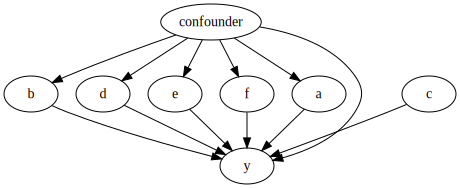

In [2]:
SEED = 10
np.random.seed(SEED)
tf.random.set_random_seed(SEED)

data_generation_graph = CausalGraphicalModel(
    nodes=['a', 'b', 'c', 'confounder',
          'd',  'e', 'f', 'y'],
    edges=[
        ("a", "y"),
        ("b", "y"),
        ("c", "y"),
        ("d", "y"),
        ("e", "y"),
        ("f", "y"),
        ("confounder", "y"),


        ("confounder", "a"),
        ("confounder", "b"),
#         ("confounder", "c"),
        ("confounder", "d"),
        ("confounder", "e"),
        ("confounder", "f"),




#         ("confounder", "y"),
#         ("confounder", "y"),
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
data_generation_graph.draw()

## Specifiy the paramteric relationship between the covariates.

This is where we specify the relationship between the variables in the Causal graph above. Specifically, we have an equation that relates each two connected nodes on the graph (so an equation for each edge).

In the outcome model for y, the coefficient on each of the variables a, b, c, d, e and f represents it's $true$ causal effect. The coefficient on the confounder, however, does not represent its causal effect, because it has 5 decendents that are part of the outcome model.

We are not ultimately interested in the causal effect of the confounder for this exercice, and instead are interested in the coefficients on each of its descendents.

In [3]:
sample_size = 10000

confounder = np.random.normal(loc=20, scale = 10, size = sample_size)

In [4]:
a = .3*confounder + np.random.normal(loc=10,scale=3,size=sample_size)
b = -1*confounder + np.random.normal(loc=6,scale=3,size=sample_size)
c = np.random.normal(loc=15,scale=3,size=sample_size) # + .5*confounder
d = .8*confounder + np.random.normal(loc=-10,scale=3,size=sample_size)
e = .5*confounder + np.random.normal(loc=8,scale=3,size=sample_size)
f= -.3*confounder + np.random.normal(loc=-12,scale=3,size=sample_size)


df = pd.DataFrame(np.array([a,b,c,d,e,f, confounder]).T, columns = ['a', 'b', 'c',
          'd',  'e', 'f', 'confounder'])

X_columns =['a', 'b', 'c',
          'd',  'e', 'f', 'confounder']
df = (df[X_columns] - df[X_columns].mean())/df[X_columns].std()

# df['confounder'] = confounder - confounder.mean()/confounder.std()

y = (5 + 2*df['a'] + 2*df['b'] - 5*df['c'] +
     3*df['d'] + 2*df['e'] - 5*df['f'] + 7*df['confounder']
     + np.random.normal(loc=0,scale=1,size=sample_size))

df['y'] = y

coeffs_true = [5,2,2,-5,3,2,-5,7]

# plt.hist(confounder, bins = 50)

# plt.hist(f, bins = 50)

In [5]:
# df = pd.DataFrame(np.array([a,b,c,d,e,f,confounder, y]).T, columns = ['a', 'b', 'c',
#           'd',  'e', 'f', 'confounder', 'y'])
df.head()

,a,b,c,d,e,f,confounder,y
0,-0.549256,0.849666,-0.642186,-0.554713,-0.052984,0.589697,-0.758279,-0.676840
1,0.471453,-0.912992,0.008687,-0.163727,1.036457,0.156559,0.588407,7.141741
2,1.184096,-0.158833,-0.053305,0.310142,0.207925,0.381985,0.179344,9.164015
3,0.700390,-1.713274,-0.076282,1.928661,1.330674,-0.804878,1.812742,28.008102
4,-2.333770,1.594524,-0.456444,-1.138791,-0.866050,0.613895,-1.668412,-14.943351


In [6]:
# sns.pairplot(df, size=1.5)

## Bias from ommitting the confounder without adjustment

Here, we show that if we ommit the confounder, and attempt to estimate a new model for y, the coefficients obtained on each of the variables a, b, d, e, and f are all biased and do not represent the causal effect associated with each of those variables. The coefficient on c remains unbiased since c does not depend on the confounder. The purpose of this is to demonstrate that you indeed need to control for the confounder, or account for it somehow, if one knows you have confounded variables and is looking to assign causal interpretations to those variables

In [7]:
model_full = smf.ols("y ~ a+b+c+d+e+f + confounder", data=df)
results_full = model_full.fit()
results_df_full = pd.DataFrame(results_full.params, columns = ['estimated_params'])
results_df_full['std_errors'] = results_full.bse
results_df_full['True Coefficient'] = coeffs_true
results_df_full[['True Coefficient']]

,True Coefficient
Intercept,5
a,2
b,2
c,-5
d,3
e,2
f,-5
confounder,7


In [8]:
model_partial = smf.ols("y ~ a+b+c+d+e+f ", data=df) ## Ommit the confounder from OLS
results_partial = model_partial.fit()
results_df_partial = pd.DataFrame(results_partial.params, columns = ['estimated_params'])
results_df_partial['std_errors'] = results_partial.bse
results_df_partial['true_params'] = coeffs_true[:-1]
results_df_partial

,estimated_params,std_errors,true_params
Intercept,5.008365,0.017642,5
a,2.433163,0.024326,2
b,-1.472845,0.044415,2
c,-4.981724,0.017648,-5
d,5.186948,0.042186,3
e,2.895057,0.032019,2
f,-5.399752,0.024485,-5


## Factor analysis: Is there evidence of latent factors?

How do we go about checking for whether a confounder exists (in this example, we know that a confounder exist since we defined the data generating process, but in the real world, the data generating process is more often than now unknown to the analyst).

There are a multitude of tests and ways to go about answering this question. A simple, off-the-shelf check is the bartlett sphericity test, which essentially just compares the correlation matrix of our covariates to the identity matrix. This test is used to check whether our covariate space can be reduced to a lower-dimensional space of factors that explain the variation in our data.

### Tim, this would be a good place to add your other tests. I'm thinking of the bullet points below:
- We can hypothesize a causal graph, and run conditional independence tests.
- Prior predictive checks?

## Fitting a factor model using 3 PCA variations.

We fit three variations of PCA. This is not necessary indeed, but we wanted to see the robustness of our final estimates and their sensitivities to different variations of fitting the factor models.

Notice that we use all of our X variables to fit the factor model (including variable c), consistent with the recommendation in Blei et al.



In [10]:
X_columns_red = ['a', 'b', 'c', 'd', 'e', 'f']

In [11]:
X = np.array(df[X_columns_red])

### Using sklearn

In [12]:
from sklearn.decomposition import PCA

In [13]:
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(X)

### Using PPCA from Blei et. al's tutorial

/Users/timsb/dev/tr_b_causal_2020/notebooks/working/factor_models.py:112: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  log_joint = ed.make_log_joint_fn(ppca_model)




Inferred axes:
[[ 0.79445726 -0.9395475  -0.03165709  0.93185836  0.8943972  -0.8052003 ]]
Standard Deviation:
[[0.00713811 0.00621588 0.00537249 0.00519545 0.00655572 0.006293  ]]


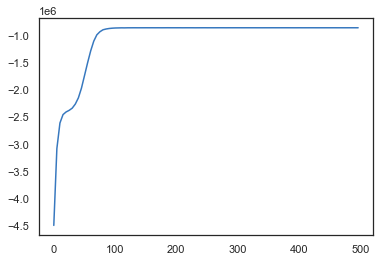

1

P-value, average:  [0.5424580524881687]


<AxesSubplot:ylabel='Density'>

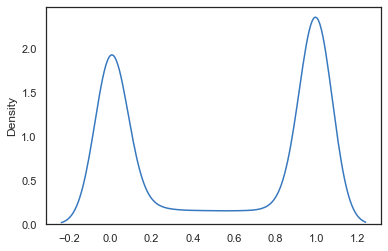

In [14]:
latent_dim = 1

confounders, holdouts, holdoutmasks, holdoutrow= confounder_ppca(holdout_portion=0.2, X=X, latent_dim=latent_dim)

holdouts_req = [holdouts]
display.display(len(holdouts_req))

confounder_req = [confounders]

n_rep = 100 # number of replicated datasets we generate
holdout_gen_util = []

for j in range(len(holdouts_req)):
    holdout_gen = np.zeros((n_rep,*(holdouts_req[j].shape)))

    for i in range(n_rep):
        w_sample = npr.normal(confounder_req[j][0], confounder_req[j][1])
        z_sample = npr.normal(confounder_req[j][2], confounder_req[j][3])

        data_dim_temp = holdouts_req[j].shape[1]
        latent_dim_temp = confounder_req[j][2].shape[1]
        num_datapoints_temp = holdouts_req[j].shape[0]

        with ed.interception(replace_latents(w_sample, z_sample)):
            generate = ppca_model(
                data_dim=data_dim_temp, latent_dim=latent_dim_temp,
                num_datapoints=num_datapoints_temp, stddv_datapoints=0.1, holdout_mask=holdoutmasks)

        with tf.Session() as sess:
            x_generated, _ = sess.run(generate)

        # look only at the heldout entries
        holdout_gen[i] = np.multiply(x_generated, holdoutmasks)

    holdout_gen_util.append(holdout_gen)


n_eval = 100 # we draw samples from the inferred Z and W
obs_ll_per_zi_per_mode = []
rep_ll_per_zi_per_mode = []
stddv_datapoints=0.1
for mode in range(len(holdouts_req)):
    obs_ll = []
    rep_ll = []

    for j in range(n_eval):
        w_sample = npr.normal(confounder_req[mode][0], confounder_req[mode][1])
        z_sample = npr.normal(confounder_req[mode][2], confounder_req[mode][3])

        holdoutmean_sample = np.multiply(z_sample.dot(w_sample), holdoutmasks)
        obs_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                            stddv_datapoints).logpdf(holdouts_req[mode]), axis=1))

        rep_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                            stddv_datapoints).logpdf(holdout_gen_util[mode]),axis=2))

    obs_ll_per_zi, rep_ll_per_zi = np.mean(np.array(obs_ll), axis=0), np.mean(np.array(rep_ll), axis=0)
    obs_ll_per_zi_per_mode.append(obs_ll_per_zi)
    rep_ll_per_zi_per_mode.append(rep_ll_per_zi)


pval_mode = []
for mode in range(len(holdouts_req)):
    pvals = np.array([np.mean(rep_ll_per_zi_per_mode[mode][:,i] < obs_ll_per_zi_per_mode[mode][i])
                      for i in range(holdouts_req[mode].shape[0])])
    holdout_subjects = np.unique(holdoutrow)
    overall_pval = np.mean(pvals[holdout_subjects])
    pval_mode.append(overall_pval)
#     print("Predictive check p-values", overall_pval)

print("P-value, average: ", pval_mode)

display.display(sns.kdeplot(pvals[holdout_subjects]))

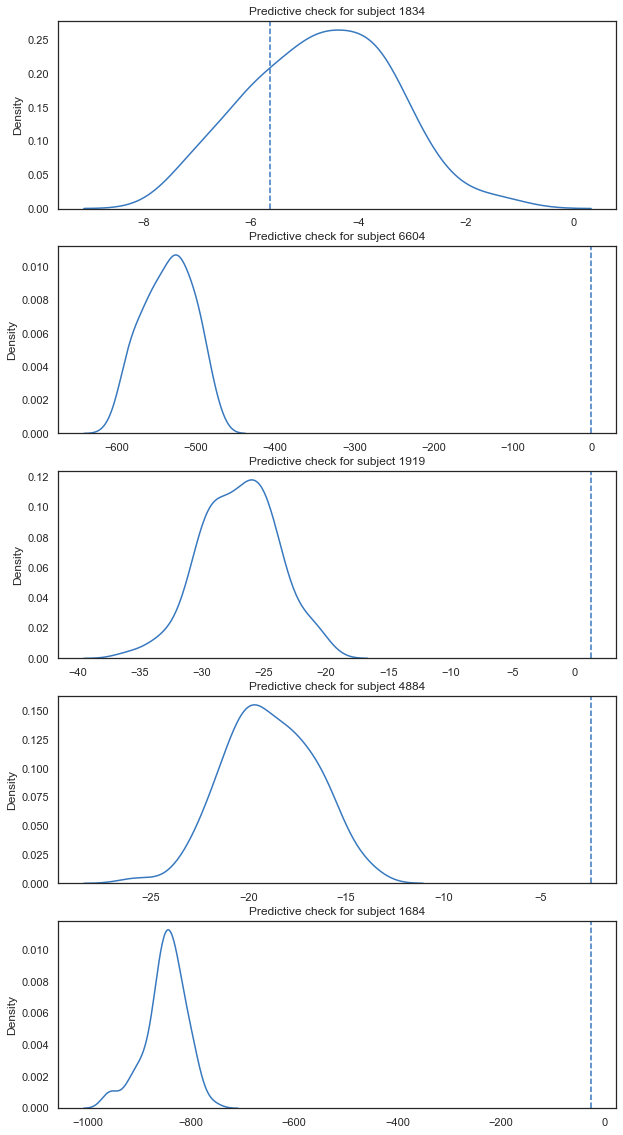

In [15]:
num_subjects = 5
fig, axes = plt.subplots(nrows = num_subjects, ncols=1, figsize = (10,20))

for i, ax in zip(range(num_subjects), axes.flat):
    subject_no = npr.choice(holdout_subjects)
    sns.kdeplot(rep_ll_per_zi[:,subject_no], ax=ax).set_title("Predictive check for subject "+str(subject_no))
    ax.axvline(x=obs_ll_per_zi[subject_no], linestyle='--')

plt.show()

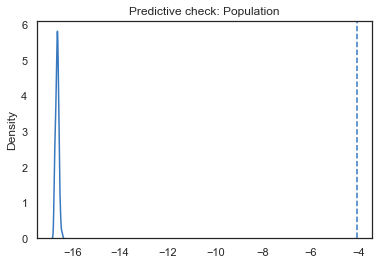

In [16]:
overall_ll_est = rep_ll_per_zi.mean(axis=1)

overall_ll_obs = obs_ll_per_zi.mean()

sns.kdeplot(overall_ll_est).set_title("Predictive check: Population")
plt.axvline(x=overall_ll_obs, linestyle='--')

In [17]:
overall_ll_est.shape

(100,)

## Visualizing the substitute confounder against the true confounder
Since we do know the values for the absolute confouder, we can actually in this case plot the recovered values against the true ones in a scatter plot and compare the fit. This is not possible in a real problem however, and we'll have to use the tests outlined in the previous sections (posterior predictive checks, etc.).

We can see that the confounder values recovered are highly correlated with the true confounder, suggesting that we $successfully$ recovered the confounder.

In [18]:
df['confounder_PCA_SKLEARN'] = principalComponents[:,0]

df['confounder_PPCA'] = confounders[2]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='confounder_PCA_SKLEARN', ylabel='confounder'>

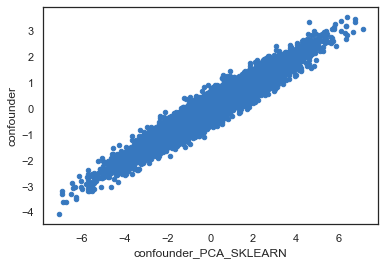

In [19]:
df.plot(kind='scatter', x = 'confounder_PCA_SKLEARN', y = 'confounder')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='confounder_PPCA', ylabel='confounder'>

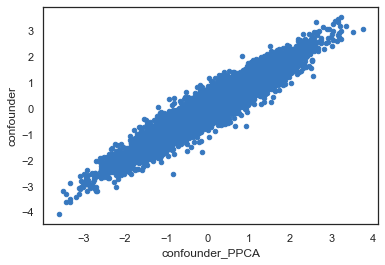

In [20]:
df.plot(kind='scatter', x = 'confounder_PPCA', y = 'confounder')

## Re-estimating regression with and without confounder

Notice that the simulation was designed such that ommitting the confounder will flip the sign of the coefficient on $b$. When we add the confounder, estimated using any PCA variation, the coefficient on $b$ remains flipped.

In addition, the bias on the coefficient estimates on our variables of interest $a, b, d, e, and f$ did not necessarily decrease in a significant way. This is surprising, since the confounder we recovered does actually correlate very well with the true confounder. The next section explores the sensitivity of those coefficients to random noise added to the true confounder.

In [21]:
model_deconf = smf.ols("y ~ a+b+c+d+e+f ", data=df)
results_deconf = model_deconf.fit()
results_df_deconf = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
results_df_deconf['std_errors'] = results_deconf.bse
results_df_deconf['true_params'] = coeffs_true[:-1]
results_df_deconf

,estimated_params,std_errors,true_params
Intercept,5.008365,0.017642,5
a,2.433163,0.024326,2
b,-1.472845,0.044415,2
c,-4.981724,0.017648,-5
d,5.186948,0.042186,3
e,2.895057,0.032019,2
f,-5.399752,0.024485,-5


In [22]:
# model_deconf = smf.ols("y ~ a+b+c+d+e+f+confounder_PCA_CV ", data=df)
# results_deconf = model_deconf.fit()
# results_df_deconf = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
# results_df_deconf['std_errors'] = results_deconf.bse
# results_df_deconf['true_params'] = coeffs_true
# results_df_deconf

In [23]:
model_deconf = smf.ols("y ~ a+b+c+d+e+f+confounder_PCA_SKLEARN ", data=df)
results_deconf = model_deconf.fit()
results_df_deconf = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
results_df_deconf['std_errors'] = results_deconf.bse
results_df_deconf['true_params'] = coeffs_true
results_df_deconf

,estimated_params,std_errors,true_params
Intercept,5.008365,0.017642,5
a,0.871512,0.024119,2
b,0.405639,0.044251,2
c,-4.936054,0.017648,-5
d,3.324756,0.042016,3
e,1.128560,0.031818,2
f,-3.830469,0.024278,-5
confounder_PCA_SKLEARN,3.875624,0.004537,7


In [24]:
model_deconf = smf.ols("y ~ a+b+c+d+e+f+confounder_PPCA ", data=df)
results_deconf = model_deconf.fit()
results_df_deconf = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
results_df_deconf['std_errors'] = results_deconf.bse
results_df_deconf['true_params'] = coeffs_true
results_df_deconf

,estimated_params,std_errors,true_params
Intercept,5.008591,0.017646,5
a,2.452384,0.035979,2
b,-1.494968,0.053886,2
c,-4.982420,0.017674,-5
d,5.208668,0.051740,3
e,2.916425,0.043517,2
f,-5.418621,0.035732,-5
confounder_PPCA,-0.090622,0.124981,7


## Adding random noise to the confounder and seeing how it affects the coefficients on the other variables

Here, we simply create a new variable, which is the original confounder plus small random noise, and substitute the true confounder with the newly created confounder in the original regression to evaluate the sensitivity of the bias of our coefficients of interest to small random deviations from the true confounder.

We find that even with very small values of the random noise (mean of 0 and standard deviation of 0.2), we still get biased estimates of our effects of interest, especially on $b$.

In [25]:
"""
We add random noise from a normal distribution of mean zero. We control the spread of this distribution
using the parameter 'coef', which represents the standard deviation of this normal distribution of the noise.
"""

coef=0.2

df['confounder_2'] = df['confounder'] + coef*np.random.normal(loc=0,scale = 1, size = len(df))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='confounder_2', ylabel='confounder'>

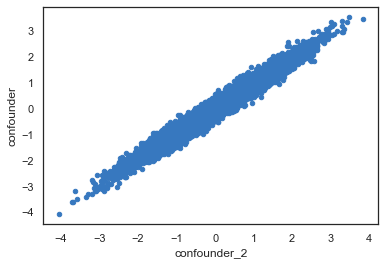

In [26]:
df.plot(kind='scatter', x = 'confounder_2', y = 'confounder')

In [27]:
model_deconf = smf.ols("y ~ a+b+c+d+e+f+confounder_2", data=df)
results_deconf = model_deconf.fit()
results_df_deconf1 = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
results_df_deconf1['std_errors'] = results_deconf.bse
results_df_deconf1['true_params'] = coeffs_true
results_df_deconf1

,estimated_params,std_errors,true_params
Intercept,5.004982,0.014167,5
a,2.211935,0.019760,2
b,0.319368,0.043072,2
c,-4.989783,0.014171,-5
d,4.033975,0.037268,3
e,2.407152,0.026538,2
f,-5.181544,0.019880,-5
confounder_2,3.676141,0.049540,7


In [28]:
results_df_deconf1.loc['b']

estimated_params    0.319368
std_errors          0.043072
true_params         2.000000
Name: b, dtype: float64

In [29]:
b_est = []
b_std = []

coef=np.arange(0,1,.05)
for i in coef:
    df['confounder_i'] = df['confounder'] + i*np.random.normal(loc=0,scale = 1, size = len(df))
    model_deconf = smf.ols("y ~ a+b+c+d+e+f+confounder_i", data=df)
    results_deconf = model_deconf.fit()
    results_df_deconf1 = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
    results_df_deconf1['std_errors'] = results_deconf.bse
    b_est.append(results_df_deconf1.loc['b'].iloc[0])
    b_std.append(results_df_deconf1.loc['b'].iloc[1])

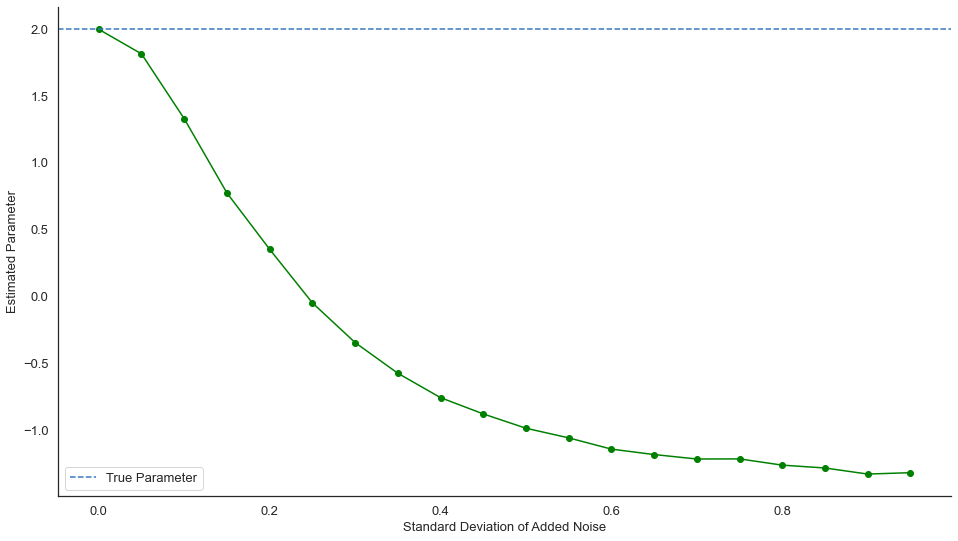

In [31]:
FONTSIZE = 13
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(coef, b_est, color = 'green', marker = 'o')
ax.axhline(2, label = 'True Parameter', ls='--')

ax.set_ylabel('Estimated Parameter', size = FONTSIZE)
ax.set_xlabel('Standard Deviation of Added Noise', size = FONTSIZE)
# ax.set_title('Sensitivity of causal effect to random noise added to the confounder', size = 20)
ax.tick_params(axis='x', labelsize=FONTSIZE)
ax.tick_params(axis='y', labelsize=FONTSIZE)
ax.legend(fontsize=FONTSIZE)
sns.despine()

fig.savefig(
    pyprojroot.here("article/images/confounder-sensitivity.pdf"),
    dpi=500,
    bbox_inches="tight"
)